# Assignment 2
The objective of this assignment is to get you familiarizewith  the  problems  of  `classification`  and  `verification`with a popular problem space of `face`

This jupyter notebook is meant to be used in conjunction with the full questions in the assignment pdf.

## Instructions
- Write your code and analyses in the indicated cells.
- Ensure that this notebook runs without errors when the cells are run in sequence.
- Do not attempt to change the contents of the other cells.

## Allowed Libraries
- All libraries are allowed 

## Datasets 
- 3 datasets are provided. Load the data from the drive [link](!https://drive.google.com/file/d/1ujsKv9W5eidb4TXt1pnsqwDKVDFtzZTh/view?usp=sharing).
- Unzip the downloaded file and store the files in a folder called `datasets`. Keep the `datasets` folder in the same directory as of the jupyter notebook 

## Submission
- Ensure that this notebook runs without errors when the cells are run in sequence.
- Rename the notebook to `<roll_number>.ipynb` and submit ONLY the notebook file on moodle.
- Upload  the  notebook,  report  and  classification  results as a zip file to moodle. Name the zip file as `<rollnumber>_assignment2.zip`

In [2]:
# Basic Imports
import os
import sys
import warnings
import numpy as  np
import pandas as pd
from scipy import linalg

# Loading and plotting data
from PIL import Image
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D

# Features
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.discriminant_analysis import _class_means,_class_cov
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE
from sklearn.utils.validation import check_is_fitted
from sklearn.utils import check_array, check_X_y

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn import svm
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score

plt.ion()
%matplotlib inline

# Parameters
- Image size: Bigger images create better representation but would require more computation. Choose the correct image size based on your Laptop configuration. 
- is_grayscale: Should you take grayscale images? Or rgb images? Choose whichever gives better representation for classification. 

In [3]:
opt = {
    'image_size': 32,
    'is_grayscale': False,
    'val_split': 0.75
}

### Load Dataset

In [4]:
cfw_dict = {'Amitabhbachan': 0,
    'AamirKhan': 1,
    'DwayneJohnson': 2,
    'AishwaryaRai': 3,
    'BarackObama': 4,
    'NarendraModi': 5,
    'ManmohanSingh': 6,
    'VladimirPutin': 7}

imfdb_dict = {'MadhuriDixit': 0,
     'Kajol': 1,
     'SharukhKhan': 2,
     'ShilpaShetty': 3,
     'AmitabhBachan': 4,
     'KatrinaKaif': 5,
     'AkshayKumar': 6,
     'Amir': 7}

# Load Image using PIL for dataset
def load_image(path):
    im = Image.open(path).convert('L' if opt['is_grayscale'] else 'RGB')
    im = im.resize((opt['image_size'],opt['image_size']))
    im = np.array(im)
    im = im/256
    return im

# Load the full data from directory
def load_data(dir_path):
    image_list = []
    y_list = []
    
    if "CFW" in dir_path:
        label_dict = cfw_dict

    elif "yale" in dir_path.lower():
        label_dict = {}
        for i in range(15):
            label_dict[str(i+1)] = i
    elif "IMFDB" in dir_path:
        label_dict = imfdb_dict
    else:
        raise KeyError("Dataset not found.")
    
    
    for filename in sorted(os.listdir(dir_path)):
        if filename.endswith(".png"):
            im = load_image(os.path.join(dir_path,filename))
            y = filename.split('_')[0]
            y = label_dict[y] 
            image_list.append(im)
            y_list.append(y)
        else:
            continue

    image_list = np.array(image_list)
    y_list = np.array(y_list)

    print("Dataset shape:",image_list.shape)

    return image_list,y_list

# Display N Images in a nice format
def disply_images(imgs,classes,row=1,col=2,w=64,h=64):
    fig=plt.figure(figsize=(8, 8))
    for i in range(1, col*row +1):
        img = imgs[i-1]
        fig.add_subplot(row, col, i)
        
        if opt['is_grayscale']:
            plt.imshow(img , cmap='gray') 
        else:
            plt.imshow(img)
        
        plt.title("Class:{}".format(classes[i-1]))
        plt.axis('off')
    plt.show()

In [5]:
# Loading the dataset
# eg.
dirpath = './dataset/IMFDB/'
X,y = load_data(dirpath)
N,H,W = X.shape[0:3]
print(N,H,W)
C = 1 if opt['is_grayscale'] else X.shape[3]

Dataset shape: (400, 32, 32, 3)
400 32 32


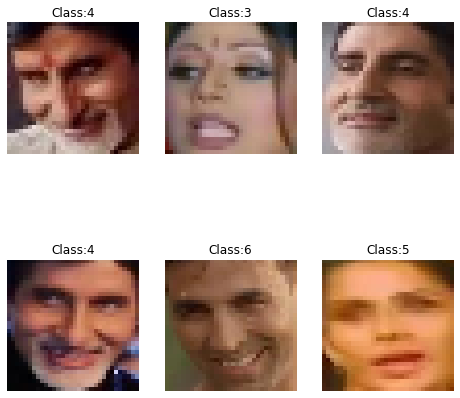

In [6]:
# Show sample images
ind = np.random.randint(0,y.shape[0],6)
disply_images(X[ind,...],y[ind], row=2,col=3)

In [7]:
# Loading the Yale dataset
# eg.
dirpath_yale = './dataset/Yale_face_database/'
X_yale,y_yale = load_data(dirpath_yale)
N_y,H_y,W_y = X_yale.shape[0:3]
print(N_y,H_y,W_y)
C_y = 1 if opt['is_grayscale'] else X_yale.shape[3]

Dataset shape: (165, 32, 32, 3)
165 32 32


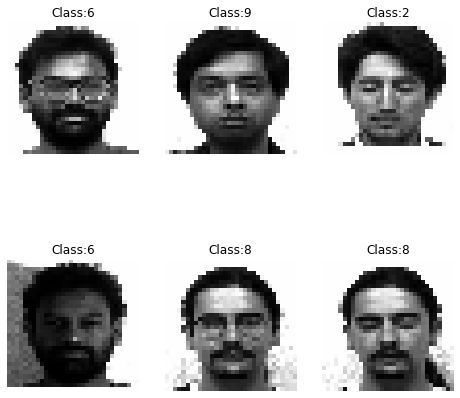

In [8]:
# Show yale sample images
ind = np.random.randint(0,y_yale.shape[0],6)
disply_images(X_yale[ind,...],y_yale[ind], row=2,col=3)

In [9]:
# Loading the cartoon dataset
# eg.
dirpath_c = './dataset/IIIT-CFW/'
X_c,y_c = load_data(dirpath_c)
N_c,H_c,W_c = X_c.shape[0:3]
print(N_c,H_c,W_c)
C_c = 1 if opt['is_grayscale'] else X_c.shape[3]

Dataset shape: (672, 32, 32, 3)
672 32 32


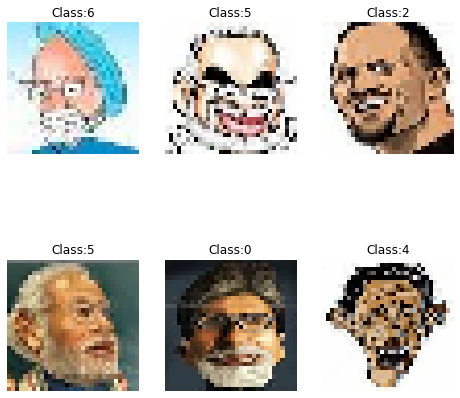

In [10]:
# Show cartoon sample images
ind = np.random.randint(0,y_c.shape[0],6)
disply_images(X_c[ind,...],y_c[ind], row=2,col=3)

# Features
    You are provided 6 Features. These features are:
   - Eigen Faces / PCA 
   - Kernel PCA
   - Fisher Face / LDA
   - Kernel Fisher Face
   - VGG Features 
   - Resnet Features

**VGG and Resnet features are last layer features learned by training a model for image classification**
    
---


In [11]:
# Flatten to apply PCA/LDA
X = X.reshape((N,H*W*C))

In [12]:
# Flatten to apply PCA/LDA
X_yale = X_yale.reshape((N_y,H_y*W_y*C_y))
X_c = X_c.reshape((N_c,H_c*W_c*C_c))

###  1. Eigen Face:
Use principal component analysis to get the eigen faces. 
Go through the [documentation](!http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) on how to use it

In [13]:
def get_pca(X,k):
    """
        Get PCA of K dimension using the top eigen vectors 
    """
    pca = PCA(n_components=k)
    X_k = pca.fit_transform(X)
    return X_k,pca

###  2. Kernel Face:
Use Kernel principal component analysis to get the eigen faces. 

There are different kernels that can be used. Eg. Poly, rbf, sigmoid. Choose the whichever gives the best result or representation. See [link](!https://data-flair.training/blogs/svm-kernel-functions/) for better understanding of these kernels  

Go through the [documentation](!https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.KernelPCA.html#sklearn.decomposition.KernelPCA) on how to use it different kernels in Sklearn. 

In [14]:
def get_kernel_pca(X, k,kernel='rbf', degree=3):
    """
        Get PCA of K dimension using the top eigen vectors 
        @param: X => Your data flattened to D dimension
        @param: k => Number of components
        @param: kernel => which kernel to use (“linear” | “poly” | “rbf” | “sigmoid” | “cosine” )
        @param: d => Degree for poly kernels. Ignored by other kernels
    """
    kpca = KernelPCA(n_components=k,kernel=kernel,degree=degree,fit_inverse_transform=True)
    X_k = kpca.fit_transform(X)
    
#     print("k")
    return X_k,kpca

### 3. Fisher Face
Another method similar to the eigenface technique is `fisherfaces` which uses linear discriminant analysis.
This method for facial recognition is less sensitive to variation in lighting and pose of the face than using eigenfaces. Fisherface uses labelled data to retain more of the class-specific information during the dimension reduction stage.

Go through the [documentation](!https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html) on how to use it different kernels in Sklearn. 

In [15]:
def get_lda(X,y, k):
    """
        Get LDA of K dimension 
        @param: X => Your data flattened to D dimension
        @param: k => Number of components
    """
    lda = LDA(n_components=k)
    X_k = lda.fit_transform(X,y)
    return X_k,lda

### 4. Kernel Fisher Face
Use LDA using different kernels similiar to KernelPCA. Here the input is directly transformed instead of using the kernel trick.  

In [16]:
def get_kernel_lda(X,y,k,kernel='rbf',degree=3):
    """
        Get LDA of K dimension 
        @param: X => Your data flattened to D dimension
        @param: k => Number of components
        @param: kernel => which kernel to use ( “poly” | “rbf” | “sigmoid”)
    """
    # Transform  input
    if kernel == "poly":
        X_transformed = X**degree
    elif kernel == "rbf":
        var = np.var(X)
        X_transformed= np.exp(-X/(2*var))
    elif kernel == "sigmoid":
        X_transformed = np.tanh(X)
    else: 
        raise NotImplementedError("Kernel {} Not defined".format(kernel))
        
    klda = LDA(n_components=k)
    X_k = klda.fit_transform(X,y)
    return X_k

### 5. VGG Features
VGG Neural Networks a 19 layer CNN architecture introduced by Andrew Zisserman([Link](!https://arxiv.org/pdf/1409.1556.pdf) to paper). We are providing you with the last fully connected layer of this model.

The model was trained for face classification on each dataset and each feature the dimension of 4096.

In [17]:
def get_vgg_features(dirpath):
    features = np.load(os.path.join(dirpath,"VGG19_features.npy"))
    return features

### 6. Resnet Features

[Residual neural networks](!https://arxiv.org/pdf/1512.03385.pdf) are CNN with large depth, to effectively train these netwrorks they utilize skip connections, or short-cuts to jump over some layers. This helps solving [vanishing gradient problem](!https://en.wikipedia.org/wiki/Vanishing_gradient_problem) 

A 50 layer resnet model was trained for face classification on each dataset. Each feature the dimension of 2048

In [18]:
def get_resnet_features(dirpath):
    features = np.load(os.path.join(dirpath,"resnet50_features.npy"))
    return features

# Questions

1(a). What are eigen faces? 


ans : Eigenfaces is the name given to a set of eigenvectors when they are used in the computer vision problem of human face recognition. Eigen faces are the set of basis vectors spanning an m dimensional sub-space which are
used to represent all the possible set of valid faces in an n dimensional space where m < n.


1(b).  How many eigen vec-tors/faces are required to “satisfactorily” reconstruct a  person  in  these  three  datasets? (Don’t  forget  to make your argument based on eigen value spectrum) Show appropriate graphs, qualitative examples and make a convincing argument.


ans:For finding the number of eigenvectors required to satisfactorily reconstruct a  person  in  these  three datasets , we should find the ratio m , such that m < 5% or m <10%

\begin{equation*}
m = \frac{( \sum_{i=k+1}^d \lambda_i )}{ ( \sum_{i=1}^d \lambda_i )}
\end{equation*}

To find this graphically , we can look at the eigenvalue spectrum and then find where the graph meets almost meets zero , we take the number of eigenvalues at this particular point.

Accordingly , I have taken the following number of eigenvalues for each of the datasets :
\begin{equation*}
IMFDB = 120
\end{equation*}
\begin{equation*}
Yale = 50
\end{equation*}
\begin{equation*}
IIIT-CFW = 400
\end{equation*}


In [19]:

# Compute your features for IMFDB 

X_3D,pca = get_pca(X,120)
X_3Dk,kpca = get_kernel_pca(X,120,'rbf',3)

# Compute your features for Yale

X_3D_y,pca_y = get_pca(X_yale,50)
X_3Dk_y,kpca_y = get_kernel_pca(X_yale,50,'rbf',3)

# Compute your features for IIIT-CFW

X_3D_c,pca_c = get_pca(X_c,400)
X_3Dk_c,kpca_c = get_kernel_pca(X_c,400,'rbf',3)

Text(0.5, 0.92, 'IIIT-CFW')

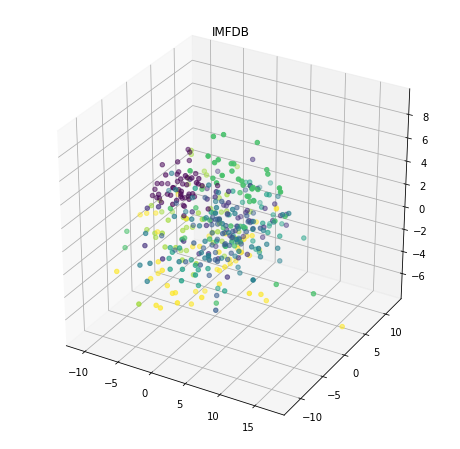

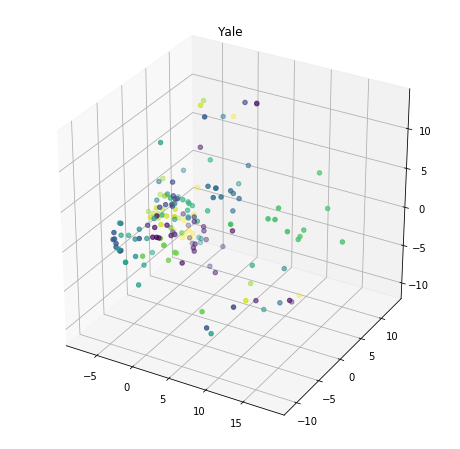

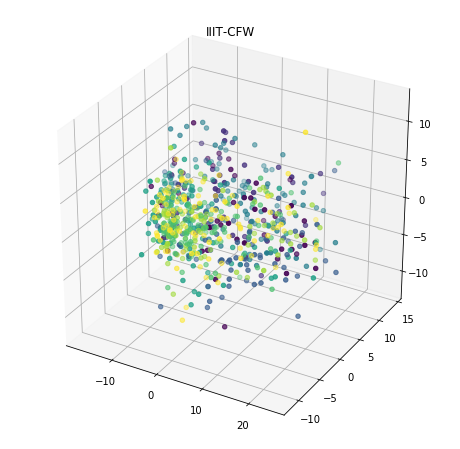

In [21]:
# Create a scatter plot  

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_3D[:,0],X_3D[:,1],X_3D[:,2],c=y)
plt.title("IMFDB")

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_3D_y[:,0],X_3D_y[:,1],X_3D_y[:,2],c=y_yale)
plt.title("Yale")

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_3D_c[:,0],X_3D_c[:,1],X_3D_c[:,2],c=y_c)
plt.title("IIIT-CFW")

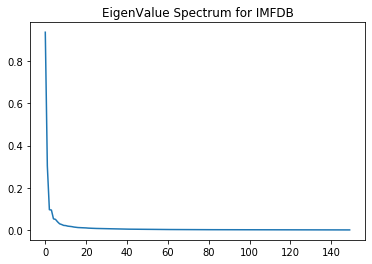

In [22]:
# Plot the eigen value spectrum for IMFDB

from numpy import linalg as LA

cov_m = np.cov(X)
eigval,eigvect = LA.eig(cov_m)
nor_eigval = eigval.real/LA.norm(eigval)

# print(np.linalg.matrix_rank(cov_m))
# plt.figure(figsize=(20,20))
plt.title("EigenValue Spectrum for IMFDB")
plt.plot(nor_eigval[:150])
plt.show()

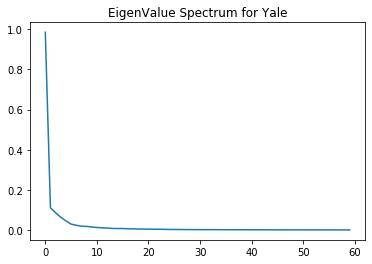

In [23]:
# Plot the eigen value spectrum for Yale

from numpy import linalg as LA

cov_m = np.cov(X_yale)
eigval,eigvect = LA.eig(cov_m)
nor_eigval_y = eigval.real/LA.norm(eigval)

# print(np.linalg.matrix_rank(cov_m))
# plt.figure(figsize=(20,20))
plt.title("EigenValue Spectrum for Yale")
plt.plot(nor_eigval_y[:60])
plt.show()

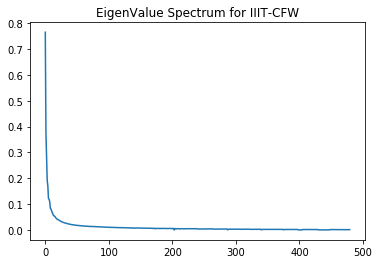

In [24]:
# Plot the eigen value spectrum for Cartoon 

from numpy import linalg as LA

cov_m = np.cov(X_c)
eigval,eigvect = LA.eig(cov_m)
nor_eigval_c = eigval.real/LA.norm(eigval)

# print(np.linalg.matrix_rank(cov_m))
# plt.figure(figsize=(20,20))
plt.title("EigenValue Spectrum for IIIT-CFW")
plt.plot(nor_eigval_c[:480])
plt.show()

1(c). Reconstruct  the  image  back for each case




In [25]:

def reconstruct_images(feature,eig_top,transformer,X):
    """
        Reconstruct the images back by just using the selected principal components. 


        You have to write the code in this code block.
        You can change the functions provided above (eg, get_pca, get_lda) for your use case. 
            
        @params: 
                Input parameters

        @return reconstructed_X => reconstructed image
        
    """
    
    if feature=="pca":
        reconstruct_X = transformer.inverse_transform(X)
    if feature=="kpca":
        reconstruct_X = transformer.inverse_transform(X)
    if feature=="lda":
        if lda.solver == 'lsqr':
            raise NotImplementedError("(inverse) transform not implemented for 'lsqr' "
                                  "solver (use 'svd' or 'eigen').")
            check_is_fitted(lda, ['xbar_', 'scalings_'], all_or_any=any)
            inv = np.linalg.pinv(lda.scalings_)
            X = check_array(X)
        if lda.solver == 'svd':
            reconstruct_X = np.dot(X, inv) + lda.xbar_
        elif lda.solver == 'eigen':
            reconstruct_X = np.dot(X, inv)
  
    return reconstruct_X    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[372 300  51 244  51 261]


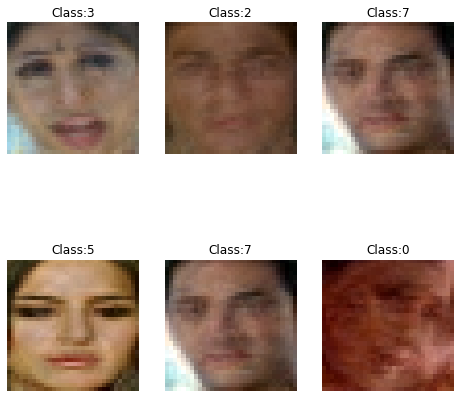

Reconstruction Error for IMFDB after PCA
0.03947275256710789


In [26]:
# Display results for PCA IMFDB

top_no = 40
X_reconstructed = reconstruct_images("pca",top_no,pca,X_3D)

X_reconstructed_3D = []

for j in range(400):
    a = np.array(X_reconstructed[j,:])
    d = a.reshape(32,32,3)
    X_reconstructed_3D.append(d)

X_reconstructed_3D = np.array(X_reconstructed_3D)

# Display random images

ind = np.random.randint(0,y.shape[0],6)
print(ind)

disply_images(X_reconstructed_3D[ind,...],y[ind],row=2,col=3)


# Show the reconstruction error
print("Reconstruction Error for IMFDB after PCA")
print(np.sqrt(np.mean((X - X_reconstructed)**2)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


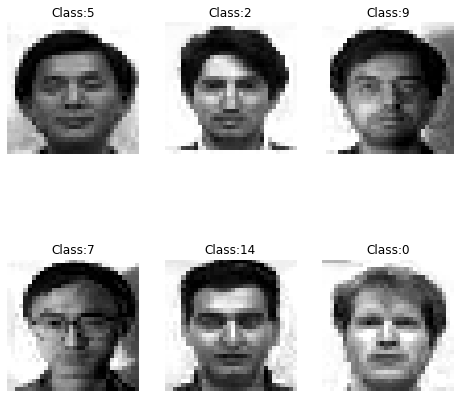

Reconstruction Error for Yale database after PCA
0.06270873066368772


In [27]:
# Display results for PCA Yale

top_no = 40
X_reconstructed_y = reconstruct_images("pca",top_no,pca_y,X_3D_y)

X_reconstructed_3D_y = []

for j in range(165):
    a = np.array(X_reconstructed_y[j,:])
    d = a.reshape(32,32,3)
    X_reconstructed_3D_y.append(d)

X_reconstructed_3D_y = np.array(X_reconstructed_3D_y)

# Display random images
ind = np.random.randint(0,y_yale.shape[0],6)

disply_images(X_reconstructed_3D_y[ind,...],y_yale[ind],row=2,col=3)


# Show the reconstruction error
print("Reconstruction Error for Yale database after PCA")
print(np.sqrt(np.mean((X_yale - X_reconstructed_y)**2)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


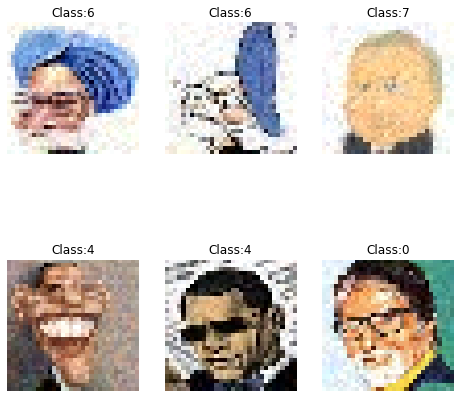

Reconstruction Error for IIIT-CFW after PCA
0.04768587133384193


In [28]:
# Display results for PCA cartoon DB

top_no = 40
X_reconstructed_c = reconstruct_images("pca",top_no,pca_c,X_3D_c)


X_reconstructed_3D_c = []

for j in range(672):
    a = np.array(X_reconstructed_c[j,:])
    d = a.reshape(32,32,3)
    X_reconstructed_3D_c.append(d)

X_reconstructed_3D_c = np.array(X_reconstructed_3D_c)

# Display random images
ind = np.random.randint(0,y_c.shape[0],6)


disply_images(X_reconstructed_3D_c[ind,...],y_c[ind],row=2,col=3)


# Show the reconstruction error
print("Reconstruction Error for IIIT-CFW after PCA")
print(np.sqrt(np.mean((X_c - X_reconstructed_c)**2)))

1(d). Which person/identity is difficult to represent com-pactly with fewer eigen vectors?  Why is that?  Explain with your empirical observations and intuitive answers

In [29]:
#Checking person most difficult to represent for IMFDB

amitabh = []
amitabh_reconstruct = []
aamir = []
aamir_reconstruct = []
dwayne = []
dwayne_reconstruct = []
aish = []
aish_reconstruct = []
obama = []
obama_reconstruct = []
modi = []
modi_reconstruct = []
manmohan = []
manmohan_reconstruct = []
putin = []
putin_reconstruct = []

        
for i in range(400):        
    if y[i]==0:
        amitabh_reconstruct.append(X_reconstructed[i])
        amitabh.append(X[i])
    if y[i]==1:
        aamir_reconstruct.append(X_reconstructed[i])
        aamir.append(X[i])
    if y[i]==2:
        dwayne_reconstruct.append(X_reconstructed[i])
        dwayne.append(X[i])
    if y[i]==3:
        aish_reconstruct.append(X_reconstructed[i])
        aish.append(X[i])
    if y[i]==4:
        obama_reconstruct.append(X_reconstructed[i])
        obama.append(X[i])
    if y[i]==5:
        modi_reconstruct.append(X_reconstructed[i])
        modi.append(X[i])
    if y[i]==6:
        manmohan_reconstruct.append(X_reconstructed[i])
        manmohan.append(X[i])
    if y[i]==7:
        putin_reconstruct.append(X_reconstructed[i])
        putin.append(X[i])

        
        
amitabh_reconstruct = np.array(amitabh_reconstruct)
aamir_reconstruct = np.array(aamir_reconstruct)
dwayne_reconstruct = np.array(dwayne_reconstruct)
aish_reconstruct = np.array(aish_reconstruct)
obama_reconstruct = np.array(obama_reconstruct)
modi_reconstruct = np.array(modi_reconstruct)
manmohan_reconstruct = np.array(manmohan_reconstruct)
putin_reconstruct = np.array(putin_reconstruct)

print("Error for reconstructing amitabh:")
amb_err = np.sqrt(np.mean((amitabh - amitabh_reconstruct)**2))
print(amb_err)
print("Error for reconstructing aamir:")
aamir_err = np.sqrt(np.mean((aamir - aamir_reconstruct)**2))
print(aamir_err)
print("Error for reconstructing dwayne:")
dwayne_err = np.sqrt(np.mean((dwayne - dwayne_reconstruct)**2))
print(dwayne_err)
print("Error for reconstructing aish:")
aish_err = np.sqrt(np.mean((aish - aish_reconstruct)**2))
print(aish_err)
print("Error for reconstructing obama:")
obama_err = np.sqrt(np.mean((obama - obama_reconstruct)**2))
print(obama_err)
print("Error for reconstructing modi:")
modi_err = np.sqrt(np.mean((modi - modi_reconstruct)**2))
print(modi_err)
print("Error for reconstructing manmohan:")
man_err = np.sqrt(np.mean((manmohan - manmohan_reconstruct)**2))
print(man_err)
print("Error for reconstructing putin:")
putin_err = np.sqrt(np.mean((putin - putin_reconstruct)**2))
print(putin_err)

print(" ")
print("Maximum error for reconstructing Manmohan Singh")
print("Most difficult person to represent is Manmohan Singh")

#Checking person most difficult to represent for IIIT-CFW
dixit = []
dixit_reconstruct = []
kajol = []
kajol_reconstruct = []
khan = []
khan_reconstruct = []
shilpa = []
shilpa_reconstruct = []
amit = []
amit_reconstruct = []
kaif = []
kaif_reconstruct = []
akshay = []
akshay_reconstruct = []
amir = []
amir_reconstruct = []

        
for i in range(400):        
    if y[i]==0:
        dixit_reconstruct.append(X_reconstructed[i])
        dixit.append(X[i])
    if y[i]==1:
        kajol_reconstruct.append(X_reconstructed[i])
        kajol.append(X[i])
    if y[i]==2:
        khan_reconstruct.append(X_reconstructed[i])
        khan.append(X[i])
    if y[i]==3:
        shilpa_reconstruct.append(X_reconstructed[i])
        shilpa.append(X[i])
    if y[i]==4:
        amit_reconstruct.append(X_reconstructed[i])
        amit.append(X[i])
    if y[i]==5:
        kaif_reconstruct.append(X_reconstructed[i])
        kaif.append(X[i])
    if y[i]==6:
        akshay_reconstruct.append(X_reconstructed[i])
        akshay.append(X[i])
    if y[i]==7:
        amir_reconstruct.append(X_reconstructed[i])
        amir.append(X[i])

        
        
dixit_reconstruct = np.array(dixit_reconstruct)
kajol_reconstruct = np.array(kajol_reconstruct)
khan_reconstruct = np.array(khan_reconstruct)
shilpa_reconstruct = np.array(shilpa_reconstruct)
amit_reconstruct = np.array(amit_reconstruct)
kaif_reconstruct = np.array(kaif_reconstruct)
akshay_reconstruct = np.array(akshay_reconstruct)
amir_reconstruct = np.array(amir_reconstruct)
print(" ")

print("Error for reconstructing dixit:")
dixit_err = np.sqrt(np.mean((dixit - dixit_reconstruct)**2))
print(dixit_err)
print("Error for reconstructing kajol:")
kajol_err = np.sqrt(np.mean((kajol - kajol_reconstruct)**2))
print(kajol_err)
print("Error for reconstructing khan:")
dwayne_err = np.sqrt(np.mean((khan - khan_reconstruct)**2))
print(dwayne_err)
print("Error for reconstructing shilpa:")
shilpa_err = np.sqrt(np.mean((shilpa - shilpa_reconstruct)**2))
print(shilpa_err)
print("Error for reconstructing amit:")
amit_err = np.sqrt(np.mean((amit - amit_reconstruct)**2))
print(amit_err)
print("Error for reconstructing kaif:")
kaif_err = np.sqrt(np.mean((kaif - kaif_reconstruct)**2))
print(kaif_err)
print("Error for reconstructing akshay:")
akshay_err = np.sqrt(np.mean((akshay - akshay_reconstruct)**2))
print(akshay_err)
print("Error for reconstructing amir:")
amir_err = np.sqrt(np.mean((amir - amir_reconstruct)**2))
print(amir_err)

print(" ")
print("Maximum error for reconstructing Shaarukh Khan")
print("Most difficult person to represent is Shaarukh Khan")

Error for reconstructing amitabh:
0.03795178676727022
Error for reconstructing aamir:
0.03914321956349502
Error for reconstructing dwayne:
0.04089343421372476
Error for reconstructing aish:
0.0397261116517608
Error for reconstructing obama:
0.039768937961520825
Error for reconstructing modi:
0.03882761094991108
Error for reconstructing manmohan:
0.0407029153241983
Error for reconstructing putin:
0.03867738075224914
 
Maximum error for reconstructing Manmohan Singh
Most difficult person to represent is Manmohan Singh
 
Error for reconstructing dixit:
0.03795178676727022
Error for reconstructing kajol:
0.03914321956349502
Error for reconstructing khan:
0.04089343421372476
Error for reconstructing shilpa:
0.0397261116517608
Error for reconstructing amit:
0.039768937961520825
Error for reconstructing kaif:
0.03882761094991108
Error for reconstructing akshay:
0.0407029153241983
Error for reconstructing amir:
0.03867738075224914
 
Maximum error for reconstructing Shaarukh Khan
Most difficult

2(a). Use any classifier(MLP, Logistic regression, SVM, Decision Trees) and find the classification accuracy. 
    
    Accuracies for all the different methods for the three datasets have been tabulated below

2(b)Which method works well? Do a comparitivestudy. 
    
    On using PCA, 
    For IMFDB , accuracy for Logistic Regression is the highest
    For Yale , accuracy for SVM is the highest
    For IIIT-CFW , accuracy for MLP is the highest
    
    On using Kernel PCA, 
    For IMFDB , accuracy for SVM is the highest
    For Yale , accuracy for SVM is the highest
    For IIIT-CFW , accuracy for SVM is the highest
    
NOTE : THE TEST TRAIN SPLIT WAS PERFORMED FIRST BEFORE FEATURE EXTRACTION AS TO MAKE SURE THAT WE DO NOT END UP TRAINING ON OUR TEST SET WHILE WE PERFORM FEATURE EXTRACTION.

You already know the paper [Face Recognition Us-ing  Kernel  Methods](!http://face-rec.org/algorithms/Kernel/nips01.pdf) .See  this  as  an  example for empirical analysis of different features/classification.

In [30]:
# Define your classifier here. You can use libraries like sklearn to create your classifier 


class Classifier():
    def __init__(self,X_train,y_train,X_validate,y_validate):
        self.X_train = X_train
        self.y_train = y_train
        self.X_validate = X_validate
        self.y_validate = y_validate
    # Define your parameters eg, W,b, max_iterations etc. 
    
    def classify(self,X,clfr_):
        """
            Given an input X classify it into appropriate class. 
        """
        prediction = clfr_.predict(X)
        return prediction
        
        
    def accuracy(self,confusion_matrix):
        diagonal_sum = confusion_matrix.trace()
        sum_of_all_elements = confusion_matrix.sum()
        acc = diagonal_sum / sum_of_all_elements    
        return acc
    def train(self,X_train,y_train,X_validate,classifier):
        """
            Given your training data, learn the parameters of your classifier
            
            @param X_train => NxD tensor. Where N is the number of samples and D is the dimension. 
                                it is the data on which your classifier will be trained. 
                            It can be any combination of features provided above.

            @param y_train => N vector. Ground truth label 
    
            @return Nothing
        """
        if classifier=="LogisticReg":
            clf = LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial').fit(X_train, y_train)
            y_prediction = clf.predict(X_validate)
        if classifier=="svm":
            clf = svm.SVC(gamma='scale', decision_function_shape='ovo')
            clf.fit(X_train, y_train)
            y_prediction = clf.predict(X_validate)
        if classifier=="mlp":
            mlp = MLPClassifier(hidden_layer_sizes=(50,), max_iter=10, alpha=1e-4,solver='lbfgs', verbose=10, tol=1e-4, random_state=10,learning_rate_init=.1)
            mlp.fit(X_train, y_train)
            y_prediction = mlp.predict(X_validate)
        if classifier=="decisiontree": 
            clf_gini = DecisionTreeClassifier(criterion = "gini", random_state = 100,max_depth=16, min_samples_leaf=5)
            clf_gini.fit(X_train, y_train)
            y_prediction = clf_gini.predict(X_validate)
        return y_prediction 
    
    def validate(self,X_validate,y_validate,y_pred):
        """
            How good is the classifier on unseen data? Use the function below to calculate different metrics. 
            Based on these matrix change the hyperparmeters and judge the classification
            
            @param X_validate => NxD tensor. Where N is the number of samples and D is the dimension. 
                                it is the data on which your classifier validated. 
                                It can be any combination of features provided above.

            @param y_validate => N vector. Ground truth label 
            
        """
        
        # Create a confusion matrix
        cm = confusion_matrix(y_pred,y_validate)
        
        # Calculate Validation accuracy 
        val_acc = self.accuracy(cm)
        
        # Calculate precision and recall 
        precision = precision_score(y_validate, y_pred, average='weighted')
        recall = recall_score(y_validate, y_pred, average='weighted') 
        
        # Calculate F1-score
        f1_score_ = f1_score(y_validate, y_pred, average='weighted')  
        return val_acc,f1_score_,cm

In [31]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
X_train_y, X_test_y, y_train_y, y_test_y = train_test_split(X_yale, y_yale, test_size=0.33, random_state=42)
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_c, y_c, test_size=0.33, random_state=42)

X_pca,pca = get_pca(X_train,120)
X_pcat = pca.transform(X_test)

# print(X_pca.shape, X_train.shape)


classifier_imfdb = Classifier(X_pca,y_train,X_pcat,y_test)
y_prediction_imfdb_lr = classifier_imfdb.train(X_pca,y_train,X_pcat,"LogisticReg")
accuracy_imfdb_lr,f1_imfdb_lr,cm_imfdb_lr = classifier_imfdb.validate(X_pcat,y_test,y_prediction_imfdb_lr)

print("Using PCA")
print("Accuracies for IMFDB")
print("Accuracy for Logistic Reg:")
print(accuracy_imfdb_lr)
err_imfdb_lr = 1 - accuracy_imfdb_lr

y_prediction_imfdb_svm = classifier_imfdb.train(X_pca,y_train,X_pcat,"svm")
accuracy_imfdb_svm,f1_imfdb_svm,cm_imfdb_svm = classifier_imfdb.validate(X_pcat,y_test,y_prediction_imfdb_svm)
print("Accuracy for svm:")
print(accuracy_imfdb_svm)
err_imfdb_svm = 1 - accuracy_imfdb_svm

y_prediction_imfdb_mlp = classifier_imfdb.train(X_pca,y_train,X_pcat,"mlp")
accuracy_imfdb_mlp,f1_imfdb_mlp,cm_imfdb_mlp = classifier_imfdb.validate(X_pcat,y_test,y_prediction_imfdb_mlp)
print("Accuracy for MLP:")
print(accuracy_imfdb_mlp)
err_imfdb_mlp = 1 - accuracy_imfdb_mlp

y_prediction_imfdb_dt = classifier_imfdb.train(X_pca,y_train,X_pcat,"decisiontree")
accuracy_imfdb_dt,f1_imfdb_dt,cm_imfdb_dt = classifier_imfdb.validate(X_pcat,y_test,y_prediction_imfdb_dt)
print("Accuracy for Decision Tree:")
print(accuracy_imfdb_dt)
err_imfdb_dt = 1 - accuracy_imfdb_dt




Using PCA
Accuracies for IMFDB
Accuracy for Logistic Reg:
0.7954545454545454
Accuracy for svm:
0.8181818181818182
Accuracy for MLP:
0.8484848484848485
Accuracy for Decision Tree:
0.4318181818181818


/Users/GowriL/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [32]:
X_pca_y,pca_y = get_pca(X_train_y,50)
X_pcat_y = pca_y.transform(X_test_y)

classifier_y = Classifier(X_pca_y,y_train_y,X_pcat_y,y_test_y)
y_prediction_y_lr = classifier_y.train(X_pca_y,y_train_y,X_pcat_y,"LogisticReg")
accuracy_y_lr,f1_y_lr,cm_y_lr = classifier_y.validate(X_pcat_y,y_test_y,y_prediction_y_lr)
print("Using PCA")
print("Accuracies for Yale")
print("Accuracy for Logistic Reg:")
print(accuracy_y_lr)
err_y_lr = 1 - accuracy_y_lr

y_prediction_y_svm = classifier_y.train(X_pca_y,y_train_y,X_pcat_y,"svm")
accuracy_y_svm,f1_y_svm,cm_y_svm = classifier_y.validate(X_pcat_y,y_test_y,y_prediction_y_svm)
print("Accuracy for svm:")
print(accuracy_y_svm)
err_y_svm = 1 - accuracy_y_svm 

y_prediction_y_mlp = classifier_y.train(X_pca_y,y_train_y,X_pcat_y,"mlp")
accuracy_y_mlp,f1_y_mlp,cm_y_mlp = classifier_y.validate(X_pcat_y,y_test_y,y_prediction_y_mlp)
print("Accuracy for MLP:")
print(accuracy_y_mlp)
err_y_mlp = 1 - accuracy_y_mlp

y_prediction_y_dt = classifier_y.train(X_pca_y,y_train_y,X_pcat_y,"decisiontree")
accuracy_y_dt,f1_y_dt,cm_y_dt = classifier_y.validate(X_pcat_y,y_test_y,y_prediction_y_dt)
print("Accuracy for Decision Tree:")
print(accuracy_y_dt)
err_y_dt = 1 - accuracy_y_dt


Using PCA
Accuracies for Yale
Accuracy for Logistic Reg:
0.8545454545454545
Accuracy for svm:
0.7272727272727273
Accuracy for MLP:
0.8
Accuracy for Decision Tree:
0.4727272727272727


/Users/GowriL/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/GowriL/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/GowriL/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [33]:
X_pca_c,pca_c = get_pca(X_train_c,400)
X_pcat_c = pca_c.transform(X_test_c)

X_lda_c,lda_c = get_lda(X_pca_c,y_train_c,400)
X_ldat_c= lda_c.transform(X_pcat_c)


classifier_c = Classifier(X_pca_c,y_train_c,X_pcat_c,y_test_c)
y_prediction_c_lr = classifier_c.train(X_pca_c,y_train_c,X_pcat_c,"LogisticReg")
accuracy_c_lr,f1_c_lr,cm_c_lr = classifier_c.validate(X_pcat_c,y_test_c,y_prediction_c_lr)
print("Using PCA")
print("Accuracies for IIIT-CFW")
print("Accuracy for Logistic Reg:")
print(accuracy_c_lr)
err_c_lr = 1 - accuracy_c_lr

y_prediction_c_svm = classifier_c.train(X_pca_c,y_train_c,X_pcat_c,"svm")
accuracy_c_svm,f1_c_svm,cm_c_svm = classifier_c.validate(X_pcat_c,y_test_c,y_prediction_c_svm)
print("Accuracy for svm:")
print(accuracy_c_svm)
err_c_svm = 1 - accuracy_c_svm

y_prediction_c_mlp = classifier_c.train(X_pca_c,y_train_c,X_pcat_c,"mlp")
accuracy_c_mlp,f1_c_mlp,cm_c_mlp = classifier_c.validate(X_pcat_c,y_test_c,y_prediction_c_mlp)
print("Accuracy for MLP:")
print(accuracy_c_mlp)
err_c_mlp = 1 - accuracy_c_mlp

y_prediction_c_dt = classifier_c.train(X_pca_c,y_train_c,X_pcat_c,"decisiontree")
accuracy_c_dt,f1_c_dt,cm_c_dt = classifier_c.validate(X_pcat_c,y_test_c,y_prediction_c_dt)
print("Accuracy for Decision Tree:")
print(accuracy_c_dt)
err_c_dt = 1 - accuracy_c_dt


/Users/GowriL/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Using PCA
Accuracies for IIIT-CFW
Accuracy for Logistic Reg:
0.5540540540540541
Accuracy for svm:
0.545045045045045
Accuracy for MLP:
0.5585585585585585
Accuracy for Decision Tree:
0.24774774774774774


In [34]:
#Using Kernel PCA

X_kpca,kpca = get_kernel_pca(X_train,120,'rbf',3)
X_kpcat = kpca.transform(X_test)


classifier_imfdbk = Classifier(X_kpca,y_train,X_kpcat,y_test)
y_prediction_imfdb_lrk = classifier_imfdbk.train(X_kpca,y_train,X_kpcat,"LogisticReg")
accuracy_imfdb_lrk,f1_imfdb_lrk,cm_imfdb_lrk = classifier_imfdbk.validate(X_kpcat,y_test,y_prediction_imfdb_lrk)
print("Using Kernel PCA on IMFDB")
print("Accuracies for IMFDB")
print("Accuracy for Logistic Reg:")
print(accuracy_imfdb_lrk)
err_imfdb_lrk = 1 - accuracy_imfdb_lrk

y_prediction_imfdb_svmk = classifier_imfdbk.train(X_kpca,y_train,X_kpcat,"svm")
accuracy_imfdb_svmk,f1_imfdb_svmk,cm_imfdb_svmk = classifier_imfdbk.validate(X_kpcat,y_test,y_prediction_imfdb_svmk)
print("Accuracy for svm:")
print(accuracy_imfdb_svmk)
err_imfdb_svmk = 1 - accuracy_imfdb_svmk

y_prediction_imfdb_mlpk = classifier_imfdbk.train(X_kpca,y_train,X_kpcat,"mlp")
accuracy_imfdb_mlpk,f1_imfdb_mlpk,cm_imfdb_mlpk = classifier_imfdbk.validate(X_kpcat,y_test,y_prediction_imfdb_mlpk)
print("Accuracy for MLP:")
print(accuracy_imfdb_mlpk)
err_imfdb_mlpk = 1 - accuracy_imfdb_mlpk

y_prediction_imfdb_dtk = classifier_imfdbk.train(X_kpca,y_train,X_kpcat,"decisiontree")
accuracy_imfdb_dtk,f1_imfdb_dtk,cm_imfdb_dtk = classifier_imfdbk.validate(X_kpcat,y_test,y_prediction_imfdb_dtk)
print("Accuracy for Decision Tree:")
print(accuracy_imfdb_dtk)
err_imfdb_dtk = 1 - accuracy_imfdb_dtk


Using Kernel PCA on IMFDB
Accuracies for IMFDB
Accuracy for Logistic Reg:
0.4090909090909091
Accuracy for svm:
0.8181818181818182
Accuracy for MLP:
0.2803030303030303
Accuracy for Decision Tree:
0.4696969696969697


/Users/GowriL/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/GowriL/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/GowriL/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/GowriL/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [35]:

##YALE

X_kpca_y,kpca_y = get_kernel_pca(X_train_y,50,'rbf',3)
X_kpcat_y = kpca_y.transform(X_test_y)

classifier_yk = Classifier(X_kpca_y,y_train_y,X_kpcat_y,y_test_y)
y_prediction_y_lrk = classifier_yk.train(X_kpca_y,y_train_y,X_kpcat_y,"LogisticReg")
accuracy_y_lrk,f1_y_lrk,cm_y_lrk = classifier_yk.validate(X_kpcat_y,y_test_y,y_prediction_y_lrk)
print("Using Kernel PCA on Yale")
print("Accuracies for Yale")
print("Accuracy for Logistic Reg:")
print(accuracy_y_lrk)
err_y_lrk = 1 - accuracy_y_lrk

y_prediction_y_svmk = classifier_yk.train(X_kpca_y,y_train_y,X_kpcat_y,"svm")
accuracy_y_svmk,f1_y_svmk,cm_y_svmk = classifier_yk.validate(X_kpcat_y,y_test_y,y_prediction_y_svmk)
print("Accuracy for svm:")
print(accuracy_y_svmk)
err_y_svmk = 1 - accuracy_y_svmk

y_prediction_y_mlpk = classifier_yk.train(X_kpca_y,y_train_y,X_kpcat_y,"mlp")
accuracy_y_mlpk,f1_y_mlpk,cm_y_mlpk = classifier_yk.validate(X_kpcat_y,y_test_y,y_prediction_y_mlpk)
print("Accuracy for MLP:")
print(accuracy_y_mlpk)
err_y_mlpk = 1 - accuracy_y_mlpk

y_prediction_y_dtk = classifier_yk.train(X_kpca_y,y_train_y,X_kpcat_y,"decisiontree")
accuracy_y_dtk,f1_y_dtk,cm_y_dtk = classifier_yk.validate(X_kpcat_y,y_test_y,y_prediction_y_dtk)
print("Accuracy for Decision Tree:")
print(accuracy_y_dtk)
err_y_dtk = 1 - accuracy_y_dtk



Using Kernel PCA on Yale
Accuracies for Yale
Accuracy for Logistic Reg:
0.2545454545454545
Accuracy for svm:
0.7272727272727273
Accuracy for MLP:
0.4727272727272727
Accuracy for Decision Tree:
0.4909090909090909


/Users/GowriL/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/GowriL/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/GowriL/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/GowriL/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/GowriL/anacon

In [36]:
##CARTOON
X_kpca_c,kpca_c = get_kernel_pca(X_train_c,400,'rbf',3)
X_kpcat_c = kpca_c.transform(X_test_c)

classifier_ck = Classifier(X_kpca_c,y_train_c,X_kpcat_c,y_test_c)
y_prediction_c_lrk = classifier_ck.train(X_kpca_c,y_train_c,X_kpcat_c,"LogisticReg")
accuracy_c_lrk,f1_c_lrk,cm_c_lrk = classifier_ck.validate(X_kpcat_c,y_test_c,y_prediction_c_lrk)
print("Using Kernel PCA on IIIT-CFW")
print("Accuracies for IIIT-CFw")
print("Accuracy for Logistic Reg:")
print(accuracy_c_lrk)
err_c_lrk = 1 - accuracy_c_lrk

y_prediction_c_svmk = classifier_ck.train(X_kpca_c,y_train_c,X_kpcat_c,"svm")
accuracy_c_svmk,f1_c_svmk,cm_c_svmk = classifier_ck.validate(X_kpcat_c,y_test_c,y_prediction_c_svmk)
print("Accuracy for svm:")
print(accuracy_c_svmk)
err_c_svmk = 1 - accuracy_c_svmk

y_prediction_c_mlpk = classifier_ck.train(X_kpca_c,y_train_c,X_kpcat_c,"mlp")
accuracy_c_mlpk,f1_c_mlpk,cm_c_mlpk = classifier_ck.validate(X_kpcat_c,y_test_c,y_prediction_c_mlpk)
print("Accuracy for MLP:")
print(accuracy_c_mlpk)
err_c_mlpk = 1 - accuracy_c_mlpk

y_prediction_c_dtk = classifier_ck.train(X_kpca_c,y_train_c,X_kpcat_c,"decisiontree")
accuracy_c_dtk,f1_c_dtk,cm_c_dtk = classifier_ck.validate(X_kpcat_c,y_test_c,y_prediction_c_dtk)
print("Accuracy for Decision Tree:")
print(accuracy_c_dtk)
err_c_dtk = 1 - accuracy_c_dtk



/Users/GowriL/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/GowriL/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Using Kernel PCA on IIIT-CFW
Accuracies for IIIT-CFw
Accuracy for Logistic Reg:
0.38738738738738737
Accuracy for svm:
0.5540540540540541
Accuracy for MLP:
0.3918918918918919
Accuracy for Decision Tree:
0.24774774774774774


/Users/GowriL/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/GowriL/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [37]:
# Create 3 tables simiar to page-6 of the paper. One table per dataset 
# Each table will have 5 columns. 
# Feature/combination of feature used, reduced dimension space, classification error, accuracy, f1-score

# Print the table. (You can use Pandas)
import pandas as pd 
print("TABLE FOR IMFDB")
Method = ['PCA+LR','PCA+SVM','PCA+MLP','PCA+DT','KPCA+LR','KPCA+SVM','KPCA+MLP','KPCA+DT',]
Reduced_Space = [120,120,120,120,120,120,120,120]
Classification_Error = [err_imfdb_lr,err_imfdb_svm,err_imfdb_mlp,err_imfdb_dt,err_imfdb_lrk,err_imfdb_svmk,err_imfdb_mlpk,err_imfdb_dtk]
Accuracy = [accuracy_imfdb_lr,accuracy_imfdb_svm,accuracy_imfdb_mlp,accuracy_imfdb_dt,accuracy_imfdb_lrk,accuracy_imfdb_svmk,accuracy_imfdb_mlpk,accuracy_imfdb_dtk]
F1Score = [f1_imfdb_lr,f1_imfdb_svm,f1_imfdb_mlp,f1_imfdb_dt,f1_imfdb_lrk,f1_imfdb_svmk,f1_imfdb_mlpk,f1_imfdb_dtk]
CM = [cm_imfdb_lr,cm_imfdb_svm,cm_imfdb_mlp,cm_imfdb_dt,cm_imfdb_lrk,cm_imfdb_svmk,cm_imfdb_mlpk,cm_imfdb_dtk]

list_of_tuples = list(zip(Method,Reduced_Space,Classification_Error,Accuracy,F1Score))
df = pd.DataFrame(list_of_tuples,columns = ['Method','Reduced_Space','Classification_Error','Accuracy','F1Score'])
df


TABLE FOR IMFDB


,Method,Reduced_Space,Classification_Error,Accuracy,F1Score
0,PCA+LR,120,0.204545,0.795455,0.793329
1,PCA+SVM,120,0.181818,0.818182,0.812721
2,PCA+MLP,120,0.151515,0.848485,0.847954
3,PCA+DT,120,0.568182,0.431818,0.439855
4,KPCA+LR,120,0.590909,0.409091,0.308761
5,KPCA+SVM,120,0.181818,0.818182,0.812721
6,KPCA+MLP,120,0.719697,0.280303,0.158031
7,KPCA+DT,120,0.530303,0.469697,0.471301


In [38]:
print("TABLE FOR YALE")
Method = ['PCA+LR','PCA+SVM','PCA+MLP','PCA+DT','KPCA+LR','KPCA+SVM','KPCA+MLP','KPCA+DT']
Reduced_Space = [50,50,50,50,50,50,50,50]
Classification_Error = [err_y_lr,err_y_svm,err_y_mlp,err_y_dt,err_y_lrk,err_y_svmk,err_y_mlpk,err_y_dtk]
Accuracy_y = [accuracy_y_lr,accuracy_y_svm,accuracy_y_mlp,accuracy_y_dt,accuracy_y_lrk,accuracy_y_svmk,accuracy_y_mlpk,accuracy_y_dtk]
F1Score = [f1_y_lr,f1_y_svm,f1_y_mlp,f1_y_dt,f1_y_lr,f1_y_svm,f1_y_mlpk,f1_y_dtk]
CM_y = [cm_y_lr,cm_y_svm,cm_y_mlp,cm_y_dt,cm_y_lr,cm_y_svm,cm_y_mlpk,cm_y_dtk]

list_of_tuples = list(zip(Method,Reduced_Space,Classification_Error,Accuracy_y,F1Score))
df = pd.DataFrame(list_of_tuples,columns = ['Method','Reduced_Space','Classification_Error','Accuracy','F1Score'])
df


TABLE FOR YALE


,Method,Reduced_Space,Classification_Error,Accuracy,F1Score
0,PCA+LR,50,0.145455,0.854545,0.856277
1,PCA+SVM,50,0.272727,0.727273,0.741299
2,PCA+MLP,50,0.200000,0.800000,0.804224
3,PCA+DT,50,0.527273,0.472727,0.469332
4,KPCA+LR,50,0.745455,0.254545,0.856277
5,KPCA+SVM,50,0.272727,0.727273,0.741299
6,KPCA+MLP,50,0.527273,0.472727,0.427769
7,KPCA+DT,50,0.509091,0.490909,0.502645


In [39]:
print("TABLE FOR IIIT-CFW")

Method = ['PCA+LR','PCA+SVM','PCA+MLP','PCA+DT','KPCA+LR','KPCA+SVM','KPCA+MLP','KPCA+DT']

Reduced_Space = [400,400,400,400,400,400,400,400]
Classification_Error_c = [err_c_lr,err_c_svm,err_c_mlp,err_c_dt,err_c_lrk,err_c_svmk,err_c_mlpk,err_c_dtk]

Accuracy_c = [accuracy_c_lr,accuracy_c_svm,accuracy_c_mlp,accuracy_c_dt,accuracy_c_lrk,accuracy_c_svmk,accuracy_c_mlpk,accuracy_c_dtk]

F1Score = [f1_c_lr,f1_c_svm,f1_c_mlp,f1_c_dt,f1_c_lrk,f1_c_svmk,f1_c_mlpk,f1_c_dtk]

CM_c = [cm_c_lr,cm_c_svm,cm_c_mlp,cm_c_dt,cm_c_lrk,cm_c_svmk,cm_c_mlpk,cm_c_dtk]

list_of_tuples = list(zip(Method,Reduced_Space,Classification_Error,Accuracy_c,F1Score))
df = pd.DataFrame(list_of_tuples,columns = ['Method','Reduced_Space','Classification_Error','Accuracy','F1Score'])
df


TABLE FOR IIIT-CFW


,Method,Reduced_Space,Classification_Error,Accuracy,F1Score
0,PCA+LR,400,0.145455,0.554054,0.552647
1,PCA+SVM,400,0.272727,0.545045,0.540838
2,PCA+MLP,400,0.200000,0.558559,0.555589
3,PCA+DT,400,0.527273,0.247748,0.240811
4,KPCA+LR,400,0.745455,0.387387,0.335909
5,KPCA+SVM,400,0.272727,0.554054,0.551109
6,KPCA+MLP,400,0.527273,0.391892,0.360997
7,KPCA+DT,400,0.509091,0.247748,0.233528


Confusion Matrix for IMFDB
[[16  0  0  1  0  1  0  0]
 [ 0 10  0  5  0  0  1  0]
 [ 0  1 12  0  0  0  0  0]
 [ 0  1  1 12  0  1  1  1]
 [ 0  0  0  0 18  0  0  0]
 [ 0  0  0  0  0 10  0  0]
 [ 0  0  0  1  0  2 18  2]
 [ 0  0  0  0  0  1  0 16]]
 


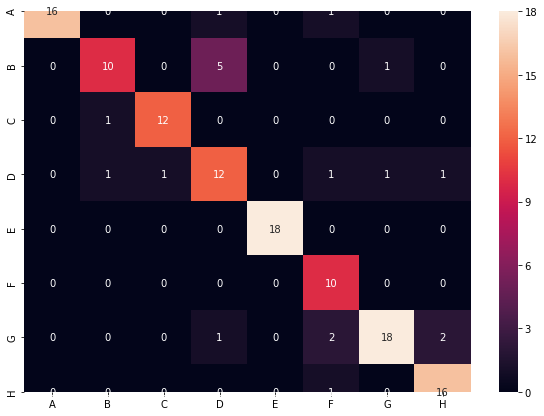

Confusion Matrix for Cartoon DB
[[ 7  0  1  4  2  0  0  2]
 [ 3  8  1  4  1  2  0  0]
 [ 0  1 16  1  5  2  2  4]
 [ 2  2  1 30  3  1  0  5]
 [ 2  3  6  0 14  1  1  3]
 [ 0  2  1  1  5 15  0  5]
 [ 0  0  2  1  2  1 17  3]
 [ 0  0  3  2  1  3  1 17]]
 


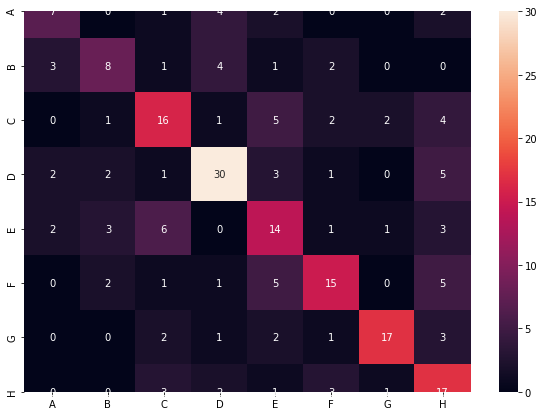

In [40]:
# For each dataset print the confusion matrix for the best model 

#For IMFDB

import seaborn as sn
max_acc_imfdb = Accuracy[0]
cm_imfdb = CM[0]
for i in range(8):
    if Accuracy[i]>max_acc_imfdb:
        max_acc_imfdb = Accuracy[i]
        cm_imfdb = CM[i]

print("Confusion Matrix for IMFDB")
print(cm_imfdb)        
print(" ")

df_cm = pd.DataFrame(cm_imfdb, index = [i for i in "ABCDEFGH"],columns = [i for i in "ABCDEFGH"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)
plt.show()

#For IIIT-CFW

max_acc_c = Accuracy_c[0]
cm_c = CM_c[0]
for i in range(8):
    if Accuracy_c[i]>max_acc_c:
        max_acc_c = Accuracy_c[i]
        cm_c = CM_c[i]
    
        
print("Confusion Matrix for Cartoon DB")        
print(cm_c)        
print(" ")

df_cm_c = pd.DataFrame(cm_c, index = [i for i in "ABCDEFGH"],columns = [i for i in "ABCDEFGH"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm_c, annot=True)
plt.show()

#For YALE
# max_acc_y = Accuracy_y[0]
# cm_y = CM_y[0]
# for i in range(8):
#     if Accuracy_y[i]>max_acc_y:
#         max_acc_y = Accuracy_y[i]
#         cm_y = CM_y[i]

# print("Confusion Matrix for YALE")
# print(cm_y)        
# print(" ")

# df_cm_y = pd.DataFrame(cm_y, index = [i for i in "ABCDEFGH"],columns = [i for i in "ABCDEFGH"])
# plt.figure(figsize = (10,7))
# sn.heatmap(df_cm_y, annot=True)
# plt.show()


3. Similiar to 1(b) use t-SNE based visilization of faces?  Does it makesense?  Do you see similar people coming together?or something else?  Can you do visualization datasetwise and combined? Here you will use a popular implementation.(Worth  reading and understanding  t-SNE.  We  will not discuss it in the class and out of scope for thiscourse/exams.




Text(0.5, 0.92, 'TSNE in 3D for IIIT-CFW')

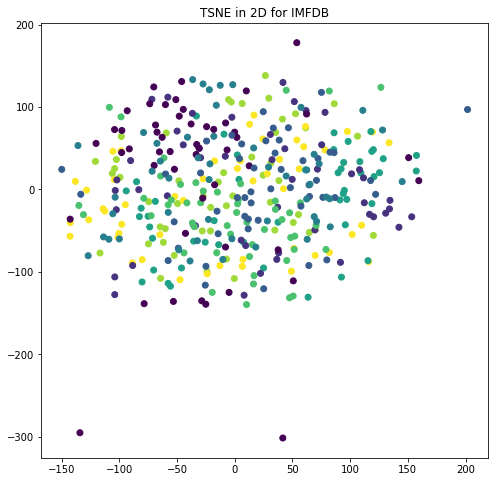

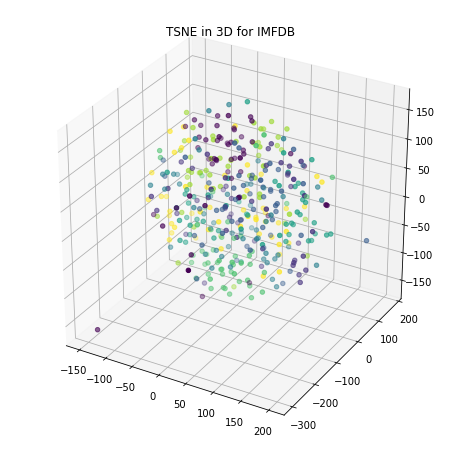

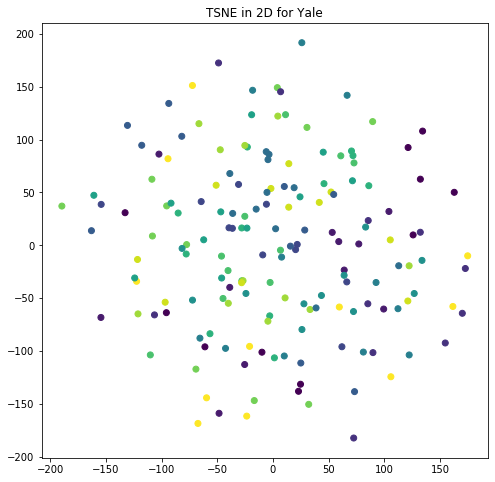

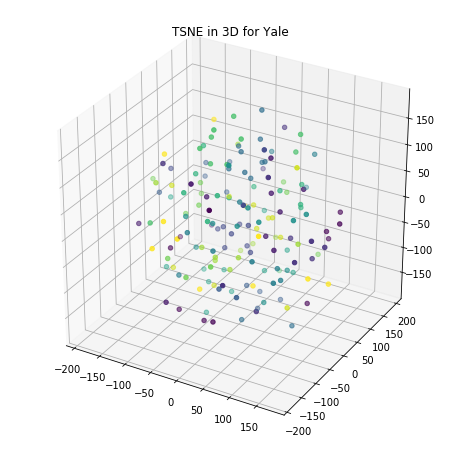

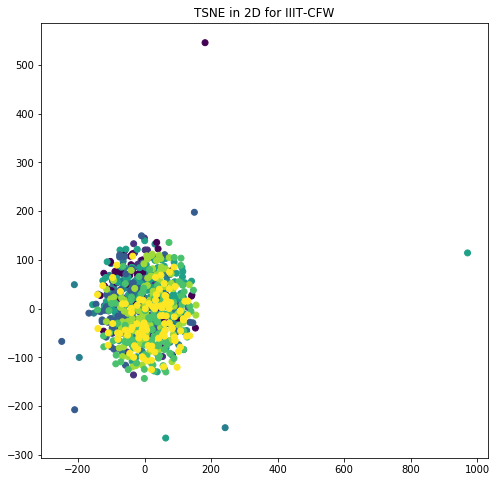

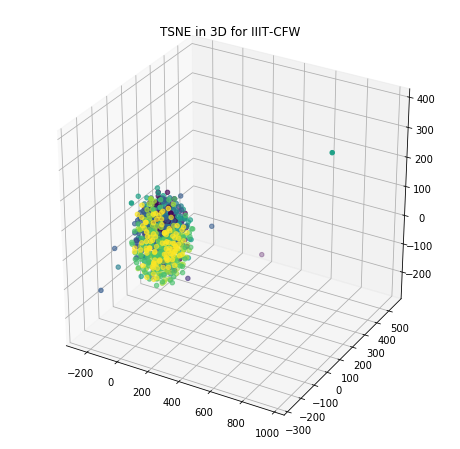

In [41]:
# Compute TSNE for different features and create a scatter plot
# !pip install seaborn --user
# !which ipython

import seaborn as sns
# X =  # feature 
k = 3 # Number of components in TSNE
# N = 10000
# np.random.seed(42)
# rndperm = np.random.permutation(df.shape[0])
# df_subset = df.loc[rndperm[:N],:].copy()

# Compute
X_TSNE = TSNE(n_components=k).fit_transform(X)
X_TSNE_y = TSNE(n_components=k).fit_transform(X_yale)
X_TSNE_c = TSNE(n_components=k).fit_transform(X_c)

# df_subset['tsne-2d-one'] = X_TSNE[:,0]
# df_subset['tsne-2d-two'] = X_TSNE[:,1]

# Plot the representation in 2d/3d
# ax2 = plt.subplot(1, 3, 2)
# sns.scatterplot(
#     x="tsne-2d-one", y="tsne-2d-two",
#     hue="y",
#     palette=sns.color_palette("hls", 10),
#     data=df_subset,
#     legend="full",
#     alpha=0.3,
# #     ax=ax2
# )


fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.scatter(X_TSNE[:,0],X_TSNE[:,1],c=y)
plt.title("TSNE in 2D for IMFDB")
    
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_TSNE[:,0],X_TSNE[:,1],X_TSNE[:,2],c=y)
plt.title("TSNE in 3D for IMFDB")



fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.scatter(X_TSNE_y[:,0],X_TSNE_y[:,1],c=y_yale)
plt.title("TSNE in 2D for Yale")
    
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_TSNE_y[:,0],X_TSNE_y[:,1],X_TSNE_y[:,2],c=y_yale)
plt.title("TSNE in 3D for Yale")


fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.scatter(X_TSNE_c[:,0],X_TSNE_c[:,1],c=y_c)
plt.title("TSNE in 2D for IIIT-CFW")
    
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_TSNE_c[:,0],X_TSNE_c[:,1],X_TSNE_c[:,2],c=y_c)
plt.title("TSNE in 3D for IIIT-CFW")

4.`face`  is  used  for  verification.   

4(a) How do we formulate the problem using KNN 
    
    This has been sklearn's K classifier in the cell below 

4(b) How do we analyze the performance ? suggest  the  metrics  (like  accuracy) that is appropriate for this task.

    The performance of the KNN Classifier can be analysed using accuracy , precision and Validation error 

4(c)Show empirical re-sults  with  all  the  representations

    This has been tabulated in the pandas table below 

In [42]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
class FaceVerification():
    def __init__(self,X_train,y_train,X_validate,y_validate):
        self.X_train = X_train
        self.y_train = y_train
        self.X_validate = X_validate
        self.y_validate = y_validate
    # Define your parameters eg, W,b, max_iterations etc. 
    
    def verify(self,X,class_id):
        """
            Given an input X find if the class id is correct or not.
            
            @return verfication_results => N vector containing True or False. 
                    If the class-id matches with your prediction then true else false.   
        """
        
        return verfication_results
        
    def train(self,X_train,y_train,X_validate,y_validate):
        """
            Given your training data, learn the parameters of your classifier
            
            @param X_train => NxD tensor. Where N is the number of samples and D is the dimension. 
                                it is the data on which your verification system will be trained. 
                                It can be any combination of features provided above.

            @param y_train => N vector. Ground truth label 
    
            @return Nothing
        """
        knn = KNeighborsClassifier(n_neighbors=7)
        knn.fit(X_train,y_train)
        y_pred = knn.predict(X_validate)
        acc = metrics.accuracy_score(y_validate, y_pred)
        prec = precision_score(y_validate, y_pred, average='weighted')
        err = 0
        for i in range(len(y_pred)):
            if y_pred[i] != y_validate[i]:
                err = err+1
        v_err = err/len(y_pred)    
        return acc,prec,v_err 
#     def validate(self,X_validate,y_validate,X_validate):
#         """
#             How good is your system on unseen data? Use the function below to calculate different metrics. 
#             Based on these matrix change the hyperparmeters
            
#             @param X_validate => NxD tensor. Where N is the number of samples and D is the dimension. 
#                                 It can be any combination of features provided above.

#             @param y_validate => N vector. Ground truth label 
            
#         """
        
        return

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_y, X_test_y, y_train_y, y_test_y = train_test_split(X_yale, y_yale, test_size=0.2, random_state=42)
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_c, y_c, test_size=0.2, random_state=42)

X_pca,pca = get_pca(X_train,120)
X_kpca,kpca = get_kernel_pca(X_train,120,'rbf',3)

X_pcat = pca.transform(X_test)
X_kpcat = kpca.transform(X_test)

X_lda,lda = get_lda(X_pca,y_train,100)
X_ldat = lda.transform(X_pcat)

FaceVerification_imfdb = FaceVerification(X_pca,y_train,X_pcat,y_test)

accuracy_imfdb_knn,prec_imfdb_knn,err_imfdb_knn = FaceVerification_imfdb.train(X_pca,y_train,X_pcat,y_test)
print("Accuracies for IMFDB")
print("Accuracy for knn:")
print(accuracy_imfdb_knn)
# err_imfdb_knn = 1 - accuracy_imfdb_knn

FaceVerification_imfdbk = FaceVerification(X_kpca,y_train,X_kpcat,y_test)

accuracy_imfdb_knnk,prec_imfdb_knnk,err_imfdb_knnk = FaceVerification_imfdbk.train(X_kpca,y_train,X_kpcat,y_test)
print("Accuracies for IMFDB")
print("Accuracy for knn:")
print(accuracy_imfdb_knnk)
# err_imfdb_knnk = 1 - accuracy_imfdb_knnk

FaceVerification_imfdbl = FaceVerification(X_lda,y_train,X_ldat,y_test)

accuracy_imfdb_knnl,prec_imfdb_knnl,err_imfdb_knnl = FaceVerification_imfdbl.train(X_lda,y_train,X_ldat,y_test)
print("Accuracies for IMFDB")
print("Accuracy for knn:")
print(accuracy_imfdb_knnl)
# err_imfdb_knn = 1 - accuracy_imfdb_knn



vgg_im = get_vgg_features('./dataset/IMFDB/')
X_train_cim, X_test_cim, y_train_cim, y_test_cim = train_test_split(vgg_im, y, test_size=0.2, random_state=42)

FaceVerification_cim = FaceVerification(X_train_cim,y_train_cim,X_test_cim,y_test_cim)

# y_prediction_imfdb_knn = FaceVerification_imfdb.train(X_train,y_train,X_test,y_test)
accuracy_c_knnim,prec_c_knnim,err_c_knnim = FaceVerification_cim.train(X_train_cim,y_train_cim,X_test_cim,y_test_cim)
print("Accuracies for imfdb")
print("Accuracy for knn:")
print(accuracy_c_knnim)
# err_c_knnk = 1 - accuracy_c_knnk


Accuracies for IMFDB
Accuracy for knn:
0.525
Accuracies for IMFDB
Accuracy for knn:
0.525
Accuracies for IMFDB
Accuracy for knn:
0.85
Accuracies for imfdb
Accuracy for knn:
0.925


In [44]:
print(X_yale.shape, X_test_y.shape)
X_pca_y,pca = get_pca(X_train_y,50)
X_kpca_y,kpca = get_kernel_pca(X_train_y,50,'rbf',3)
X_pca_yt = pca.transform(X_test_y)
X_kpca_yt = kpca.transform(X_test_y)

X_lda_y,lda = get_lda(X_pca_y,y_train_y,30)
X_lda_yt = lda.transform(X_pca_yt)

FaceVerification_y = FaceVerification(X_lda_y,y_train_y,X_lda_yt,y_test_y)

# y_prediction_imfdb_knn = FaceVerification_imfdb.train(X_train,y_train,X_test,y_test)
accuracy_y_knn,prec_y_knn,err_y_knn = FaceVerification_y.train(X_pca_y,y_train_y,X_pca_yt,y_test_y)
print("Accuracies for yale")
print("Accuracy for knn:")
print(accuracy_y_knn)
# err_y_knn = 1 - accuracy_y_knn
# Accuracy.append(accuracy_imfdb_lr)
# F1Score.append(f1_imfdb_lr)

FaceVerification_yk = FaceVerification(X_kpca_y,y_train_y,X_kpca_yt,y_test_y)

# y_prediction_imfdb_knn = FaceVerification_imfdb.train(X_train,y_train,X_test,y_test)
accuracy_y_knnk,prec_y_knnk,err_y_knnk = FaceVerification_yk.train(X_kpca_y,y_train_y,X_kpca_yt,y_test_y)
print("Accuracies for yale")
print("Accuracy for knn:")
print(accuracy_y_knnk)
# err_y_knnk = 1 - accuracy_y_knnk
# Accuracy.append(accuracy_imfdb_lr)
# F1Score.append(f1_imfdb_lr)


FaceVerification_yl = FaceVerification(X_lda_y,y_train_y,X_lda_yt,y_test)

accuracy_y_knnl,prec_y_knnl,err_y_knnl = FaceVerification_yl.train(X_lda_y,y_train_y,X_lda_yt,y_test_y)
print("Accuracies for IMFDB")
print("Accuracy for knn:")
print(accuracy_y_knnl)
# err_imfdb_knn = 1 - accuracy_imfdb_knn


vgg_y = get_vgg_features('./dataset/Yale_face_database/')
X_train_yv, X_test_yv, y_train_yv, y_test_yv = train_test_split(vgg_y, y_yale, test_size=0.2, random_state=42)

FaceVerification_yv = FaceVerification(X_train_yv,y_train_yv,X_test_yv,y_test_yv)

# y_prediction_imfdb_knn = FaceVerification_imfdb.train(X_train,y_train,X_test,y_test)
accuracy_y_knnv,prec_y_knnv,err_y_knnv = FaceVerification_yv.train(X_train_yv,y_train_yv,X_test_yv,y_test_yv)
print("Accuracies for Cartoon")
print("Accuracy for knn:")
print(accuracy_y_knnv)
# err_c_knnk = 1 - accuracy_c_knnk


(165, 3072) (33, 3072)
Accuracies for yale
Accuracy for knn:
0.6666666666666666
Accuracies for yale
Accuracy for knn:
0.6666666666666666
Accuracies for IMFDB
Accuracy for knn:
1.0
Accuracies for Cartoon
Accuracy for knn:
0.45454545454545453


/Users/GowriL/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/GowriL/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/GowriL/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [45]:
X_pca_c,pca = get_pca(X_train_c,400)
X_kpca_c,kpca = get_kernel_pca(X_train_c,400,'rbf',3)
X_pca_ct = pca.transform(X_test_c)
X_kpca_ct = kpca.transform(X_test_c)

X_lda_c,lda = get_lda(X_pca_c,y_train_c,350)
X_lda_ct = lda.transform(X_pca_ct)

FaceVerification_c = FaceVerification(X_pca_c,y_train_c,X_pca_ct,y_test_c)

# y_prediction_imfdb_knn = FaceVerification_imfdb.train(X_train,y_train,X_test,y_test)
accuracy_c_knn,prec_c_knn,err_c_knn = FaceVerification_c.train(X_pca_c,y_train_c,X_pca_ct,y_test_c)
print("Accuracies for Cartoon")
print("Accuracy for knn:")
print(accuracy_c_knn)
# err_c_knn = 1 - accuracy_c_knn
# Accuracy.append(accuracy_imfdb_lr)
# F1Score.append(f1_imfdb_lr)

FaceVerification_ck = FaceVerification(X_kpca_c,y_train_c,X_kpca_ct,y_test_c)

# y_prediction_imfdb_knn = FaceVerification_imfdb.train(X_train,y_train,X_test,y_test)
accuracy_c_knnk,prec_c_knnk,err_c_knnk = FaceVerification_ck.train(X_kpca_c,y_train_c,X_kpca_ct,y_test_c)
print("Accuracies for Cartoon")
print("Accuracy for knn:")
print(accuracy_c_knnk)
# err_c_knnk = 1 - accuracy_c_knnk

FaceVerification_cl = FaceVerification(X_lda_c,y_train_c,X_lda_ct,y_test)

accuracy_c_knnl,prec_c_knnl,err_c_knnl = FaceVerification_cl.train(X_lda_c,y_train_c,X_lda_ct,y_test_c)
print("Accuracies for IMFDB")
print("Accuracy for knn:")
print(accuracy_c_knnl)
# err_imfdb_knn = 1 - accuracy_imfdb_knn


vgg_c = get_vgg_features('./dataset/IIIT-CFW/')
X_train_cv, X_test_cv, y_train_cv, y_test_cv = train_test_split(vgg_c, y_c, test_size=0.2, random_state=42)

FaceVerification_cv = FaceVerification(X_train_cv,y_train_cv,X_test_cv,y_test_cv)

# y_prediction_imfdb_knn = FaceVerification_imfdb.train(X_train,y_train,X_test,y_test)
accuracy_c_knnv,prec_c_knnv,err_c_knnv = FaceVerification_cv.train(X_train_cv,y_train_cv,X_test_cv,y_test_cv)
print("Accuracies for Cartoon")
print("Accuracy for knn:")
print(accuracy_c_knnv)
# err_c_knnk = 1 - accuracy_c_knnk


Accuracies for Cartoon
Accuracy for knn:
0.3037037037037037
Accuracies for Cartoon
Accuracy for knn:
0.3037037037037037
Accuracies for IMFDB
Accuracy for knn:
0.42962962962962964
Accuracies for Cartoon
Accuracy for knn:
0.6814814814814815


In [46]:
# Create 3 tables simiar to page-6 of the paper. One table per dataset 
# Each table will have 5 columns. 
# Feature/combination of feature used, reduced dimension space, verification error, accuracy, precision

# Print the table. (You can use Pandas)

Method = ['PCA+KNN','KPCA+KNN','PCA+LDA+KNN','VGG+KNN']
Reduced_Space = [120,120,100,120]
Verification_Error = [err_imfdb_knn,err_imfdb_knnk,err_imfdb_knnl,err_c_knnim]

Accuracy = [accuracy_imfdb_knn,accuracy_imfdb_knnk,accuracy_imfdb_knnl,accuracy_c_knnim]
Precision = [prec_imfdb_knn,prec_imfdb_knnk,prec_imfdb_knnl,prec_c_knnim]

list_of_tuples = list(zip(Method,Reduced_Space,Verification_Error,Accuracy,Precision))
df = pd.DataFrame(list_of_tuples,columns = ['Method','Reduced_Space','Verification_Error','Accuracy','Precision'])
df


,Method,Reduced_Space,Verification_Error,Accuracy,Precision
0,PCA+KNN,120,0.475,0.525,0.714971
1,KPCA+KNN,120,0.475,0.525,0.714971
2,PCA+LDA+KNN,100,0.150,0.850,0.878348
3,VGG+KNN,120,0.075,0.925,0.927029


In [47]:
Method = ['PCA+KNN','KPCA+KNN','PCA+LDA+KNN','VGG+KNN']
Reduced_Space = [50,50,30,50]
Verification_Error = [err_y_knn,err_y_knnk,err_y_knnl,err_y_knnv]

Accuracy = [accuracy_y_knn,accuracy_y_knnk,accuracy_y_knnl,accuracy_y_knnv]
Precision = [prec_y_knn,prec_y_knnk,prec_y_knnl,prec_y_knnv]

list_of_tuples = list(zip(Method,Reduced_Space,Verification_Error,Accuracy,Precision))
df = pd.DataFrame(list_of_tuples,columns = ['Method','Reduced_Space','Verification_Error','Accuracy','Precision'])
df


,Method,Reduced_Space,Verification_Error,Accuracy,Precision
0,PCA+KNN,50,0.333333,0.666667,0.768831
1,KPCA+KNN,50,0.333333,0.666667,0.768831
2,PCA+LDA+KNN,30,0.000000,1.000000,1.000000
3,VGG+KNN,50,0.545455,0.454545,0.481818


In [48]:
Method = ['PCA+KNN','KPCA+KNN','PCA+LDA+KNN','VGG+KNN']
Reduced_Space = [400,400,350,400,400]
Verification_Error = [err_c_knn,err_c_knnk,err_c_knnl,err_c_knnv]
# ,err_imfdb_mlp,err_imfdb_dt,err_imfdb_lrk,err_imfdb_svmk,err_imfdb_mlpk,err_imfdb_dtk]
Accuracy = [accuracy_c_knn,accuracy_c_knnk,accuracy_c_knnl,accuracy_c_knnv]
Precision = [prec_c_knn,prec_c_knnk,prec_c_knnl,prec_c_knnv]
# ,accuracy_imfdb_mlp,accuracy_imfdb_dt,accuracy_imfdb_lrk,accuracy_imfdb_svmk,accuracy_imfdb_mlpk,accuracy_imfdb_dtk]
# F1Score = [f1_imfdb_knn,f1_imfdb_knn]
# ,f1_imfdb_mlp,f1_imfdb_dt,f1_imfdb_lrk,f1_imfdb_svmk,f1_imfdb_mlpk,f1_imfdb_dtk]


list_of_tuples = list(zip(Method,Reduced_Space,Verification_Error,Accuracy,Precision))
df = pd.DataFrame(list_of_tuples,columns = ['Method','Reduced_Space','Verification_Error','Accuracy','Precision'])
df


,Method,Reduced_Space,Verification_Error,Accuracy,Precision
0,PCA+KNN,400,0.696296,0.303704,0.386152
1,KPCA+KNN,400,0.696296,0.303704,0.418731
2,PCA+LDA+KNN,350,0.570370,0.429630,0.451750
3,VGG+KNN,400,0.318519,0.681481,0.710582


### Extenstion / Application
    Create a system for any one of the following problems:

- Politicians  vs  Filmstars  in  a  public  data  set.   (eg.LFW)
        You already have seen IIIT-CFW dataset. Use it for classification. 
- Age prediction
        Given different actors/actress in IMFDB create new labels based on their age.  
- Gender prediction
        Given different actors/actress in IMFDB+IIIT-CFW create new labels based on their gender.
- Emotion classification
        Both the yale dataset and IMFDB contain an `emotion.txt` file. Using that you can create a emotion predicter 
- cartoon vs real images
        Use a combination of IIIT-CFW and other dataset. 
        


You are free to use a new dataset that is publicly avail-able or even create one by crawling from internet.

# Gender prediction on IIIT-CFW + IMFDB database

Gender has been assigned as '0' for male and '1' for female. 
Then the correctly and wrongly classified images are displayed.


Dataset shape: (1072, 32, 32, 3)
1072 32 32


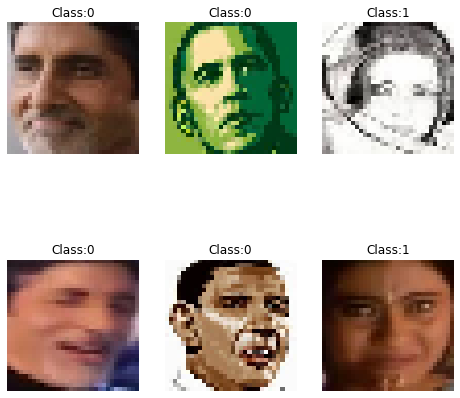

In [49]:
# Load data
cfw_dict = {'Amitabhbachan': 0,
    'AamirKhan': 0,
    'DwayneJohnson': 0,
    'AishwaryaRai': 1,
    'BarackObama': 0,
    'NarendraModi': 0,
    'ManmohanSingh': 0,
    'VladimirPutin': 0}

imfdb_dict = {'MadhuriDixit': 1,
     'Kajol': 1,
     'SharukhKhan': 0,
     'ShilpaShetty': 1,
     'AmitabhBachan': 0,
     'KatrinaKaif': 1,
     'AkshayKumar': 0,
     'Amir': 0}

# Load Image using PIL for dataset
def load_image(path):
    im = Image.open(path).convert('L' if opt['is_grayscale'] else 'RGB')
    im = im.resize((opt['image_size'],opt['image_size']))
    im = np.array(im)
    im = im/256
    return im

# Load the full data from directory
def load_data(dir_path,dir_path2):
    image_list = []
    y_list = []
    
    if "CFW" in dir_path:
        label_dict = cfw_dict

    elif "IMFDB" in dir_path:
        label_dict = imfdb_dict
    else:
        raise KeyError("Dataset not found.")
    
    
    for filename in sorted(os.listdir(dir_path)):
        if filename.endswith(".png"):
            im = load_image(os.path.join(dir_path,filename))
            y = filename.split('_')[0]
            y = label_dict[y] 
            image_list.append(im)
            y_list.append(y)
        else:
            continue

    if "CFW" in dir_path2:
        label_dict = cfw_dict

    elif "IMFDB" in dir_path2:
        label_dict = imfdb_dict
    else:
        raise KeyError("Dataset not found.")
    
    
    for filename in sorted(os.listdir(dir_path2)):
        if filename.endswith(".png"):
            im = load_image(os.path.join(dir_path2,filename))
            y = filename.split('_')[0]
            y = label_dict[y] 
            image_list.append(im)
            y_list.append(y)
        else:
            continue

    
    image_list = np.array(image_list)
    y_list = np.array(y_list)

    print("Dataset shape:",image_list.shape)

    return image_list,y_list

# Display N Images in a nice format
def disply_images(imgs,classes,row=1,col=2,w=64,h=64):
    fig=plt.figure(figsize=(8, 8))
    for i in range(1, col*row +1):
        img = imgs[i-1]
        fig.add_subplot(row, col, i)
        
        if opt['is_grayscale']:
            plt.imshow(img , cmap='gray') 
        else:
            plt.imshow(img)
        
        plt.title("Class:{}".format(classes[i-1]))
        plt.axis('off')
    plt.show()
    
# Loading the dataset
# eg.
dirpath = './dataset/IMFDB/'
dirpath_c = './dataset/IIIT-CFW/'
X,y = load_data(dirpath,dirpath_c)
N,H,W = X.shape[0:3]
print(N,H,W)
C = 1 if opt['is_grayscale'] else X.shape[3]    

# Show sample images
ind = np.random.randint(0,y.shape[0],6)
disply_images(X[ind,...],y[ind], row=2,col=3)

In [50]:


def Gender_ver(X_train,y_train,X_validate,y_validate):
    clf = svm.SVC(gamma='scale', decision_function_shape='ovo')
    clf.fit(X_train, y_train)
    y_prediction = clf.predict(X_validate)
    
#     prediction = clfr_.predict(X)
    acc = metrics.accuracy_score(y_validate, y_prediction)
    prec = precision_score(y_validate, y_prediction, average='weighted')
    err = 0
    for i in range(len(y_prediction)):
        if y_prediction[i] != y_validate[i]:
            err = err+1
    v_err = err/len(y_prediction)    
    return acc,prec,v_err,y_prediction 
    
    

In [51]:
# Define your features
X = X.reshape((N,H*W*C))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# print(X.shape,y.shape)

X_pca_c,pca = get_pca(X_train,400)
X_pca_ct = pca.transform(X_test)

# X_lda_c,lda = get_lda(X_pca_c,y_train,290)
# X_lda_ct = lda.transform(X_pca_ct)



Accuracies for Cartoon
Accuracy for pca:
0.8790697674418605
Accuracies for K-fold validation
Accuracy:
0.4666666666666667
Accuracy:
0.6
Accuracy:
0.7555555555555555
Accuracy:
0.8111111111111111
Accuracy:
0.6404494382022472
Accuracy:
0.011235955056179775
Accuracy:
0.8651685393258427
Accuracy:
0.9887640449438202
Accuracy:
0.9438202247191011
Accuracy:
1.0
Accuracy:
0.9775280898876404
Accuracy:
0.9438202247191011
 
Variance
0.08399900795042402


Text(0.5, 0.92, 'TSNE in 3D')

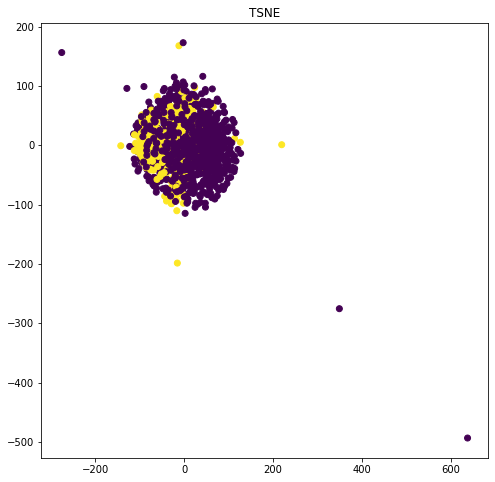

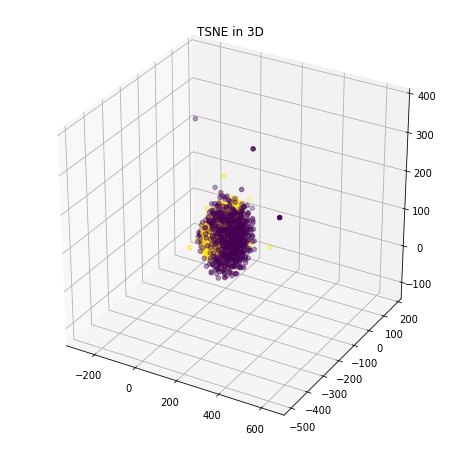

In [52]:
# Show qualitative results such as accuracy, k-fold validation, TSNE/PCA/Isomap plots, etc. 


accuracy,prec,err,y_prediction = Gender_ver(X_pca_c,y_train,X_pca_ct,y_test)
print("Accuracies for Cartoon")
print("Accuracy for pca:")
print(accuracy)

# accuracy1,prec1,err1,_ = Gender_ver(X_lda_c,y_train,X_lda_ct,y_test)

# print("Accuracies for Cartoon")
# print("Accuracy for lda+pca:")
# print(accuracy1)

from sklearn.model_selection import KFold

kf = KFold(n_splits=12)
print("Accuracies for K-fold validation")
list_acc = []
for train_index, test_index in kf.split(X):
#     print("TRAIN:", train_index, "TEST:", test_index)
    X_train_, X_test_ = X[train_index], X[test_index]
    y_train_, y_test_ = y[train_index], y[test_index]
#     clf = svm.SVC(gamma='scale', decision_function_shape='ovo')
#     clf.fit(X_train, y_train)
#     y_prediction = clf.predict(X_test)
    accuracy,_,_,_ = Gender_ver(X_train_,y_train_,X_test_,y_test_)
    list_acc.append(accuracy)
    
    print("Accuracy:")
    print(accuracy)
import statistics     
variance = statistics.variance(list_acc)
print(" ")
print("Variance")
print(variance)
    
k=3    
X_TSNE = TSNE(n_components=k).fit_transform(X)

# plt.title("TSNE")
# plt.scatter(*zip(*X_TSNE[:,:2]))
# plt.show()


fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.scatter(X_TSNE[:,0],X_TSNE[:,1],c=y)
plt.title("TSNE")    
    
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_TSNE[:,0],X_TSNE[:,1],X_TSNE[:,2],c=y)
plt.title("TSNE in 3D")    

Text(0.5, 1.0, 'PCA')

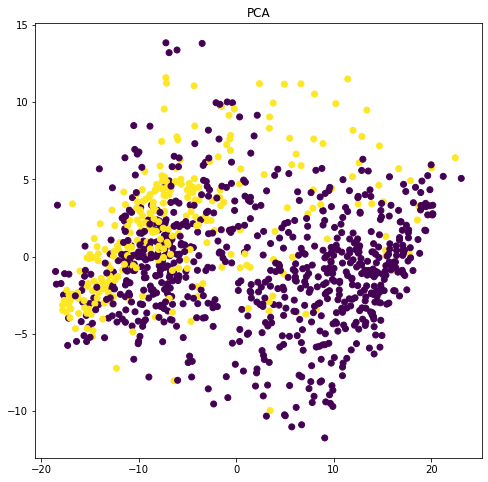

In [53]:
# from scikits.learn.pca import PCA
# pca = PCA(n_components=2)
# X_r = pca.fit_transform(X)

pca_,_ = get_pca(X,2)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.scatter(pca_[:,0],pca_[:,1],c=y)
plt.title("PCA")

Text(0.5, 1.0, 'Isomap')

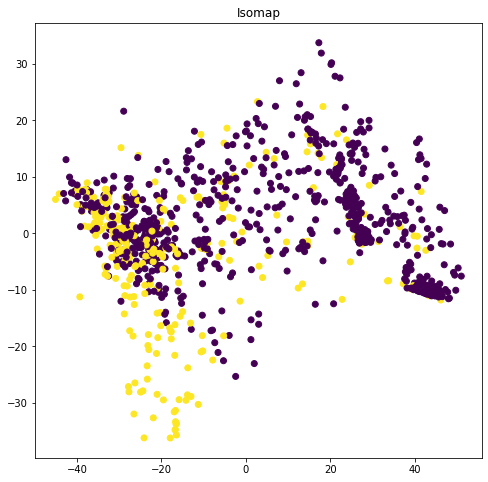

In [54]:
from sklearn.manifold import Isomap
embedding = Isomap(n_components=2)
X_transformed = embedding.fit_transform(X[:1072])

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.scatter(X_transformed[:,0],X_transformed[:,1],c=y)
plt.title("Isomap")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Correctly classified


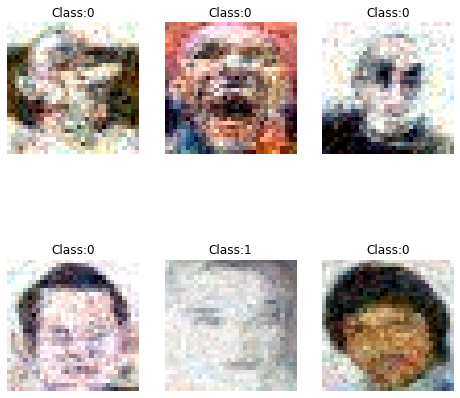

In [55]:
# Show quantitative results such as examples of correct prediction and wrong prediction
def disply_images_(imgs,classes,row=1,col=2,w=64,h=64):
    fig=plt.figure(figsize=(8, 8))
    for i in range(1, col*row +1):
        img = imgs[i-1]
        fig.add_subplot(row, col, i)
        
        if opt['is_grayscale']:
            plt.imshow(img , cmap='gray') 
        else:
            plt.imshow(img)
        
        plt.title("Class:{}".format(classes[i-1]))
        plt.axis('off')
    plt.show()



corr = []
wrong = []
pred = []
actual = []

# print(len(y_prediction))
# print(len(y))

for i in range(len(y_prediction)):
    if y_prediction[i]==y_test[i]:
        corr.append(i)
    else:
        wrong.append(i)
        pred.append(y_prediction[i])
        actual.append(y_test[i])
        
# ind = np.random.randint(0,y.shape[0],6)


print("Correctly classified")       
        
# print(X_pca_ct.shape)
X_recontructed = pca.inverse_transform(X_pca_ct)

X_reconstructed_3D = []

for j in corr:
    a = np.array(X_recontructed[j,:])
    d = a.reshape(32,32,3)
    X_reconstructed_3D.append(d)

X_reconstructed_3D = np.array(X_reconstructed_3D)

# print(X_reconstructed_3D.shape)

# Display random images
ind = corr[0:6]
# np.random.randint(0,len(corr),6)
# print(ind)

disply_images_(X_reconstructed_3D[ind,...],y_test[ind],row=2,col=3)



Wrongly classified Images


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


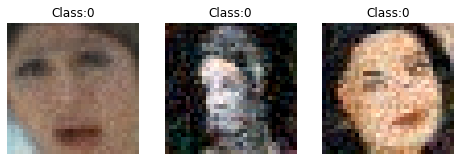

In [56]:
print("Wrongly classified Images")
X_recontructed = pca.inverse_transform(X_pca_ct)       
    
X_reconstructed_3D = []

for j in wrong:
    a = np.array(X_recontructed[j,:])
    d = a.reshape(32,32,3)
    X_reconstructed_3D.append(d)

X_reconstructed_3D = np.array(X_reconstructed_3D)

# Display random images
ind = np.arange(0,3)

disply_images_(X_reconstructed_3D[ind,...],y_test[ind],row=1,col=3)
